In [1]:
def read_fasta(file_path):
    """
    Reads a FASTA file and returns a dictionary where keys are the headers (chromosomes or enzyme names)
    and values are the corresponding sequences.
    """
    with open(file_path, 'r') as file:
        sequences = {}
        header = None # Initiating header to None
        sequence = []

        for line in file:
            line = line.strip()
            if line.startswith(">"):
                if header:
                    sequences[header] = ''.join(sequence)
                header = line[1:]  # Remove '>' character
                sequence = []
            else:
                sequence.append(line)
        
        # Add the last sequence
        if header:
            sequences[header] = ''.join(sequence)

    return sequences

In [2]:
def restriction_sites(file_path):
    """
    Reads the enzyme file and returns a dictionary where keys are the enzymes and values are a list
    consisting cutsite and the nick.
    """
    enzymes = read_fasta(file_path)
    for key in enzymes:
        nick = enzymes[key].find("|")
        enzymes[key] = [enzymes[key].replace("|", "").replace("N", "[ACTG]").replace("Y", "[CT]").replace("R", "[AG]"), nick]
        # Replace all the placeholders with the corresponding regex
    return enzymes

In [3]:
import re

def find_restriction_sites(genome, enzyme):
    """
    Finds restriction sites in the genome. Returns a dictionary where keys are headers (chromosomes)
    and values are lists of positions of the restriction site.
    """
    positions = {}
    restriction_site = restriction_sites("test_enzyme.fa")[enzyme]

    for chr, seq in genome.items():
        positions[chr] = [0]+ [restriction_site[1] + m.start() for m in re.finditer(restriction_site[0], seq)]
        # Find all the restriction sites and add the nick to the position, add the first position of the chromosome
        if positions[chr][-1] != len(seq):
            positions[chr].append(len(seq))
        # Add the last position of the chromosome

    return positions


In [4]:
def random_fragment(sites, max_size, min_size):
    """
    Input is a list of restriction sites, and the maximum and minimum size of the fragment,
    output is a list of restriction sites inserted with random break sites.
    """
    import random
    new_sites = sites.copy()  # Copy the original list to avoid modifying it
    current_position = sites[0]

    while current_position < sites[-1]:
        current_position += random.randint(min_size, max_size)
        if current_position < sites[-1]:
            new_sites.append(current_position)

    return sorted(new_sites)

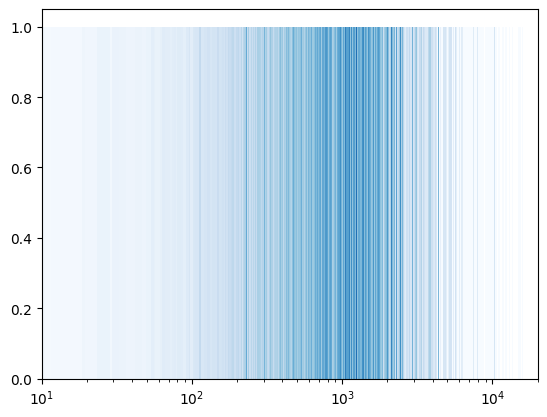

In [17]:
def main():
    import matplotlib.pyplot as plt
    from collections import Counter

    genome_file = "../genome.fa"
    enzyme_file = "test_enzyme.fa"

    # Read genome and restriction enzyme sites
    genome = read_fasta(genome_file)
    enzymes = restriction_sites(enzyme_file)
    
    # Create a dictionary to store the restriction sites for the selected enzymes
    selected_enzymes = input("Enter the names of the enzymes separated by commas (e.g., EcoRI, HindIII): ").split(',')
    
    # Find restriction sites for the selected enzymes and generate the selected_restriction_sites dictionary
    from collections import defaultdict
    selected_restriction_sites = defaultdict(set) # Use defaultdict to avoid key errors and store unique restriction sites
    for enzyme_name in selected_enzymes:
        enzyme_name = enzyme_name.strip() # Remove whitespaces
        if enzyme_name in enzymes:
            enzyme_sites = find_restriction_sites(genome, enzyme_name)
            for chr, sites in enzyme_sites.items(): # Add the restriction sites to the selected_restriction_sites dictionary
                selected_restriction_sites[chr].update(sites)
        else:
            print("{enzyme} not found!".format(enzyme=enzyme_name))
    
    for chr in selected_restriction_sites: # Sort the restriction sites and convert the set to sorted list
        selected_restriction_sites[chr] = sorted(list(selected_restriction_sites[chr]))
    
    # Simulate the fragmentation during genome DNA extraction
    distances = []
    for chr, sites in selected_restriction_sites.items():
        for i in range(100):
            sites_with_fragmentation = random_fragment(sites, 100000, 15000)
            distances_in_chr = [sites_with_fragmentation[i+1] - sites_with_fragmentation[i] for i in range(len(sites_with_fragmentation)-1)]
            distances.extend(distances_in_chr)
    
    fragment_count = Counter(distances)
    DNA_sum = sum(distances)
    intensity = {key: value*key/DNA_sum for key, value in fragment_count.items()}

    # Normalize the intensity
    max_intensity = max(intensity.values())
    normalized_intensity = {key: value/max_intensity for key, value in intensity.items()}

    # Plot the results
    cmap = plt.cm.Blues
    for size, intensity in normalized_intensity.items():
        color = cmap(intensity)
        plt.bar(size, 1, width=5, color=color)
    
    plt.xlim(10,20000)
    plt.xscale("log")

    return distances # Return the distances list to be used in the plot

if __name__ == "__main__":
    main()

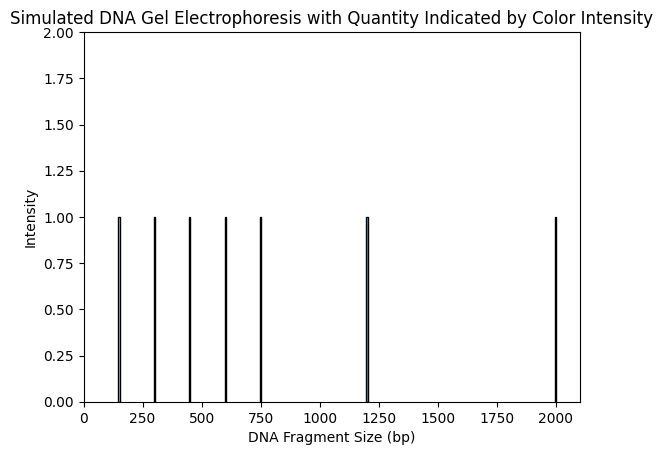

In [6]:
import matplotlib.pyplot as plt
from collections import Counter

# Example DNA fragment sizes with duplicates to indicate quantity
dna_sizes = [150, 300, 300, 450, 600, 600, 600, 750, 1200, 1200, 2000, 2000, 2000, 2000]  # Replace with your actual data

# Count the quantity of each fragment size
fragment_quantities = Counter(dna_sizes)

# Normalize the quantities to get relative intensities
max_quantity = max(fragment_quantities.values())
intensities = {size: quantity / max_quantity for size, quantity in fragment_quantities.items()}

# Define a color map
cmap = plt.cm.Blues

# Plot each DNA size as a vertical line with color intensity based on the quantity
for size, intensity in intensities.items():
    color = cmap(intensity)  # Get color from the color map
    plt.bar(size, 1, width=5, color=color, edgecolor='black')  # Added edgecolor for clarity

# Setting labels and title
plt.xlabel('DNA Fragment Size (bp)')
plt.ylabel('Intensity')
plt.title('Simulated DNA Gel Electrophoresis with Quantity Indicated by Color Intensity')
plt.xlim(0, max(dna_sizes) + 100)  # Adjust x-axis limits to fit your data
plt.ylim(0, 2)  # Y-axis limits are arbitrary

plt.show()
